In [163]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [164]:
with open('../data/matches.yml', 'r', encoding='utf8') as f:
    matches = yaml.safe_load(f)

# Check imported data to detect typos and other errors

In [4]:
countries = set()
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            countries.update(list(match.keys()))

print('Countries:', len(countries))
countries

Countries: 16


{'Alemania',
 'Croacia',
 'Dinamarca',
 'Eslovenia',
 'España',
 'Francia',
 'Hungría',
 'Montenegro',
 'Noruega',
 'Países Bajos',
 'Polonia',
 'República Checa',
 'Rumania',
 'Rusia',
 'Serbia',
 'Suecia'}

In [5]:
df = pd.read_excel('../data/Handball Woman European Data Set.xlsx', index_col=0)

In [6]:
df['Team'].unique()

array(['FRA', 'MNE', 'DEN', 'SLO', 'RUS', 'ESP', 'SWE', 'CZE', 'HUN',
       'CRO', 'ROU', 'GER', 'NOR', 'POL', 'NED', 'SRB '], dtype=object)

# Utility functions

In [27]:
def country_abbr(country_name):
    return {
        'Alemania': 'GER',
        'Croacia': 'CRO',
        'Dinamarca': 'DEN',
        'Eslovenia': 'SLO',
        'España': 'ESP',
        'Francia': 'FRA',
        'Hungría': 'HUN',
        'Montenegro': 'MNE',
        'Noruega': 'NOR',
        'Países Bajos': 'NED',
        'Polonia': 'POL',
        'República Checa': 'CZE',
        'Rumania': 'ROU',
        'Rusia': 'RUS',
        'Serbia': 'SRB',
        'Suecia': 'SWE'
    }[country_name]

def get_match(matches, match_name):
    for phase in matches:
        for group in matches[phase]:
            for match in matches[phase][group]:
                teamA, teamB = match.keys()
                teamA, teamB = country_abbr(teamA), country_abbr(teamB)
                if match_name == f"{teamA}-{teamB}" or match_name == f"{teamB}-{teamA}":
                    return match

def get_result(match, team):
    if len(team) > 3:
        team = country_abbr(team)
    
    teamA, teamB = match.keys()
    
    if match[teamA] == match[teamB]:
        return 0
    else:
        winner = teamA if match[teamA] > match[teamB] else teamB
        if team == country_abbr(winner):
            return 1
        else:
            return -1

In [8]:
match = get_match(matches, 'RUS-SWE')
print(match)
get_result(match, 'Rusia')

{'Rusia': 30, 'Suecia': 26}


1

In [9]:
simplified_df = df[['Phase', 'Match', 'Team', 'Goals']]

matches_df = simplified_df.groupby(['Phase', 'Match', 'Team']).sum().reset_index()
matches_df

,Phase,Match,Team,Goals
0,3y4,CRO-DEN,CRO,25
1,3y4,CRO-DEN,DEN,19
2,5y6,RUS-NED,NED,27
3,5y6,RUS-NED,RUS,33
4,FINAL,FRA-NOR,FRA,20
...,...,...,...,...
89,PHASE1-D,ROU-NOR,ROU,20
90,SEMI,FRA-CRO,CRO,19
91,SEMI,FRA-CRO,FRA,30
92,SEMI,NOR-DEN,DEN,24


# Initial prediction tests

In [10]:
simplified_df = df[['Match', 'Team', 'Goals','Shots']]
# Agrupamos por equipo y sumamos las estadísticas de cada uno
teams_df = simplified_df.groupby(['Match', 'Team']).sum().reset_index()

# Remove trailing white spaces in Team codes
teams_df['Team'] = teams_df.apply(lambda row: row.Team.strip(), axis=1)
teams_df

,Match,Team,Goals,Shots
0,CRO-DEN,CRO,25,48
1,CRO-DEN,DEN,19,44
2,CRO-GER,CRO,23,40
3,CRO-GER,GER,20,44
4,CRO-NED,CRO,27,44
...,...,...,...,...
89,SRB-CRO,SRB,24,38
90,SRB-HUN,HUN,38,60
91,SRB-HUN,SRB,26,54
92,SWE-CZE,CZE,23,46


In [11]:
teams_df['match_result'] = teams_df.apply(lambda row: get_result(get_match(matches, row.Match), row.Team), axis=1)
teams_df

,Match,Team,Goals,Shots,match_result
0,CRO-DEN,CRO,25,48,1
1,CRO-DEN,DEN,19,44,-1
2,CRO-GER,CRO,23,40,1
3,CRO-GER,GER,20,44,-1
4,CRO-NED,CRO,27,44,1
...,...,...,...,...,...
89,SRB-CRO,SRB,24,38,-1
90,SRB-HUN,HUN,38,60,1
91,SRB-HUN,SRB,26,54,-1
92,SWE-CZE,CZE,23,46,-1


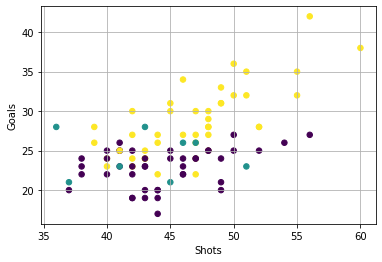

In [12]:
X = teams_df[['Shots', 'Goals', 'match_result']]

plt.scatter(X['Shots'], X['Goals'], c=X['match_result'], s=30)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.grid()

#ax = plt.gca()
#for i in range(0,len(teams_df)):
#    ax.annotate(teams_df.iloc[i,:]['Team'], (X.iloc[i,0], X.iloc[i,1]))

plt.show()

# Variables significativas y limpieza de datos

In [589]:
# ['Phase','Match','Team','No','Name','Goals','Shots','%','7m%','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','YC','RC','2M','2+2','AS','R7','ST','BS','P7','TO','Time','scoring','MVP']
teams_df_all = df.groupby(['Match', 'Team']).sum().reset_index()
teams_df_all
teams_df_all['Team'] = teams_df_all.apply(lambda row: row.Team.strip(), axis=1)
teams_df_all['match_result'] = teams_df.apply(lambda row: get_result(get_match(matches, row.Match), row.Team), axis=1)


valid_cols = ['Team','match_result','7mPGoals','7mPMissed','6mCGoals','6mCMissed','WingGoals','WingMissed','BTGoals','BTMissed','FBGoals','FBMissed','FTOGoals','FTOMissed','9mGoals','9mMissed','RC','2M','AS','R7','ST','BS','P7','TO']
valid_cols_df = teams_df_all[valid_cols]
valid_cols_df


,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO
0,CRO,4,2,8,1,7,4,2,0,0,2,0,0,4,14,0,1,17,6,4,4,0,8
1,DEN,0,0,2,0,5,6,4,1,1,2,0,0,7,16,0,2,7,0,4,7,6,10
2,CRO,2,2,8,0,5,3,2,0,0,0,0,0,6,12,0,5,13,4,0,2,9,8
3,GER,8,1,2,0,4,6,0,1,2,2,0,0,4,14,0,5,16,9,3,2,4,6
4,CRO,1,0,6,4,9,1,2,0,1,2,0,0,8,10,0,4,9,1,1,2,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,SRB,4,2,6,1,7,4,2,1,1,0,0,0,4,6,0,3,14,6,4,3,3,11
90,HUN,2,0,1,1,10,4,5,2,9,4,0,2,11,9,0,0,18,2,5,4,2,9
91,SRB,0,2,5,4,13,9,2,1,1,1,0,0,5,11,0,3,17,2,3,0,2,13
92,CZE,4,2,3,0,9,5,0,1,0,2,0,0,7,13,0,4,5,6,1,3,10,11


# Análisis PCA

Realizamos un análisis de componentes principales con distintas configuraciones para obtener las varianzas explicadas. 

In [590]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3]

X = valid_cols_df.drop('Team', 1)

In [591]:
for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=20)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 25.94% [0.15613971 0.1032349 ]
[scaler=Standard, n=3] Explained variance: 34.56% [0.15613971 0.1032349  0.08621954]
[scaler=MinMax, n=2] Explained variance: 27.12% [0.16310787 0.10806106]
[scaler=MinMax, n=3] Explained variance: 36.43% [0.16310787 0.10806106 0.09314307]


In [13]:
from sklearn import neighbors

In [14]:
clf = neighbors.KNeighborsClassifier(15, weights='uniform')
clf.fit(X[['Shots', 'Goals']], X['match_result'])

KNeighborsClassifier(n_neighbors=15)

In [17]:
h = .02  # step size in the mesh
x_min, x_max = X['Shots'].min() - 1, X['Shots'].max() + 1
y_min, y_max = X['Goals'].min() - 1, X['Goals'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

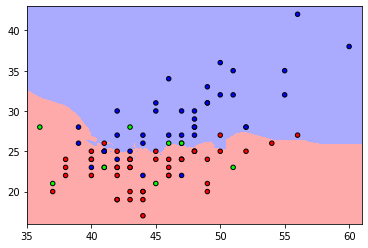

In [20]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X['Shots'], X['Goals'], c=X['match_result'], cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

# Test prediction joining both teams data

In [44]:
teams_df = pd.read_csv('../models/teams_EM.csv')
teams_df

,Unnamed: 0,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO,PC1,PC2,cluster
0,0,CRO,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98,-3.007976,4.226142,3
1,1,CZE,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40,5.047346,0.364696,0
2,2,DEN,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,-3.174269,0.759901,3
3,3,ESP,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,-0.934444,-0.324208,1
4,4,FRA,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,-4.118907,1.369064,3
5,5,GER,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72,-1.206175,0.056285,1
6,6,HUN,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79,-0.210540,-1.356587,4
7,7,MNE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,0.477307,-1.030249,4
8,8,NED,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81,-2.727188,-1.817280,1
9,9,NOR,35,9,36,14,59,40,44,15,47,18,0,0,33,50,0,18,148,44,34,33,24,75,-5.388616,-3.702451,2


In [45]:
train_matches = []
test_matches = []
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            teamA, teamB = match.keys()
            
            if match[teamA] == match[teamB]:
                winner = 0
            else:
                winner = 1 if match[teamA] > match[teamB] else 2

            if phase == 'first':
                test_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            else:
                train_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            
print("Train:", train_matches)
print("Test:", test_matches)

Train: [['MNE', 'RUS', 2], ['FRA', 'ESP', 1], ['FRA', 'RUS', 0], ['DEN', 'SWE', 1], ['MNE', 'SWE', 1], ['DEN', 'ESP', 1], ['MNE', 'ESP', 0], ['FRA', 'SWE', 1], ['DEN', 'RUS', 1], ['CRO', 'ROU', 1], ['NED', 'NOR', 2], ['HUN', 'GER', 2], ['CRO', 'NOR', 2], ['NED', 'GER', 1], ['HUN', 'ROU', 1], ['NED', 'ROU', 1], ['CRO', 'GER', 1], ['HUN', 'NOR', 2], ['RUS', 'NED', 1], ['FRA', 'CRO', 1], ['NOR', 'DEN', 1], ['CRO', 'DEN', 1], ['FRA', 'NOR', 2]]
Test: [['FRA', 'MNE', 1], ['DEN', 'SLO', 1], ['SLO', 'FRA', 2], ['MNE', 'DEN', 2], ['MNE', 'SLO', 1], ['FRA', 'DEN', 1], ['RUS', 'ESP', 1], ['SWE', 'CZE', 1], ['CZE', 'RUS', 2], ['ESP', 'SWE', 0], ['ESP', 'CZE', 1], ['RUS', 'SWE', 1], ['HUN', 'CRO', 2], ['NED', 'SRB', 2], ['SRB', 'HUN', 2], ['CRO', 'NED', 1], ['SRB', 'CRO', 2], ['NED', 'HUN', 1], ['ROU', 'GER', 2], ['NOR', 'POL', 1], ['POL', 'ROU', 2], ['GER', 'NOR', 2], ['GER', 'POL', 0], ['ROU', 'NOR', 2]]


In [116]:
team_features = ['PC1', 'PC2', 'cluster']

def generate_data(matches, teams_df, augment=False):
    data = []
    for match in matches:
        teamA, teamB, result = match
        
        teamA_data = teams_df.loc[teams_df['Team'] == teamA][team_features].values.tolist()[0]
        teamB_data = teams_df.loc[teams_df['Team'] == teamB][team_features].values.tolist()[0]
        
        data.append([teamA, teamB, *teamA_data, *teamB_data, result])
        if augment:
            data.append([
                teamB, teamA,
                *teamB_data, *teamA_data,
                {0: 0, 1: 2, 2: 1}[result]
            ])
    
    return pd.DataFrame(data=data,
                        columns=['teamA', 'teamB', *[f'A_{f}' for f in team_features], *[f'B_{f}' for f in team_features], 'result'])


In [118]:
train_df = generate_data(train_matches, teams_df, augment=True)
test_df = generate_data(test_matches, teams_df)

train_df

,teamA,teamB,A_PC1,A_PC2,A_cluster,B_PC1,B_PC2,B_cluster,result
0,MNE,RUS,0.477307,-1.030249,4.0,-1.043192,0.002938,1.0,2
1,RUS,MNE,-1.043192,0.002938,1.0,0.477307,-1.030249,4.0,1
2,FRA,ESP,-4.118907,1.369064,3.0,-0.934444,-0.324208,1.0,1
3,ESP,FRA,-0.934444,-0.324208,1.0,-4.118907,1.369064,3.0,2
4,FRA,RUS,-4.118907,1.369064,3.0,-1.043192,0.002938,1.0,0
5,RUS,FRA,-1.043192,0.002938,1.0,-4.118907,1.369064,3.0,0
6,DEN,SWE,-3.174269,0.759901,3.0,-0.262189,2.119723,1.0,1
7,SWE,DEN,-0.262189,2.119723,1.0,-3.174269,0.759901,3.0,2
8,MNE,SWE,0.477307,-1.030249,4.0,-0.262189,2.119723,1.0,1
9,SWE,MNE,-0.262189,2.119723,1.0,0.477307,-1.030249,4.0,2


In [119]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(train_df[['A_PC1', 'A_PC2', 'A_cluster', 'B_PC1', 'B_PC2', 'B_cluster']], train_df['result'])

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [120]:
pred = clf.predict(test_df[['A_PC1', 'A_PC2', 'A_cluster', 'B_PC1', 'B_PC2', 'B_cluster']])

In [121]:
pred_df = test_df.copy()
pred_df['knn'] = pred
pred_df

,teamA,teamB,A_PC1,A_PC2,A_cluster,B_PC1,B_PC2,B_cluster,result,knn
0,FRA,MNE,-4.118907,1.369064,3.0,0.477307,-1.030249,4.0,1,1
1,DEN,SLO,-3.174269,0.759901,3.0,5.650701,0.524214,0.0,1,1
2,SLO,FRA,5.650701,0.524214,0.0,-4.118907,1.369064,3.0,2,2
3,MNE,DEN,0.477307,-1.030249,4.0,-3.174269,0.759901,3.0,2,2
4,MNE,SLO,0.477307,-1.030249,4.0,5.650701,0.524214,0.0,1,1
5,FRA,DEN,-4.118907,1.369064,3.0,-3.174269,0.759901,3.0,1,1
6,RUS,ESP,-1.043192,0.002938,1.0,-0.934444,-0.324208,1.0,1,2
7,SWE,CZE,-0.262189,2.119723,1.0,5.047346,0.364696,0.0,1,2
8,CZE,RUS,5.047346,0.364696,0.0,-1.043192,0.002938,1.0,2,2
9,ESP,SWE,-0.934444,-0.324208,1.0,-0.262189,2.119723,1.0,0,1


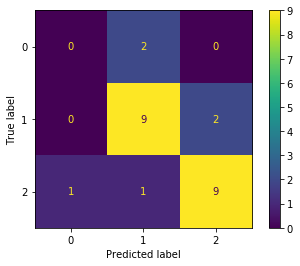

0.75

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_matrix = confusion_matrix(pred_df['result'], pred_df['knn'], labels=[0, 1, 2])
plot_confusion_matrix(
    clf,
    test_df[['A_PC1', 'A_PC2', 'A_cluster', 'B_PC1', 'B_PC2', 'B_cluster']],
    test_df['result'],
)#normalize='true')
plt.show()


np.diag(confusion_matrix).sum() / confusion_matrix.sum()

# Using all team features

In [187]:
teams_df = pd.read_csv('../models/teams_EM.csv')
teams_df

,Unnamed: 0,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,FTOGoals,FTOMissed,9mGoals,9mMissed,RC,2M,AS,R7,ST,BS,P7,TO,PC1,PC2,cluster
0,0,CRO,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98,-3.007976,4.226142,3
1,1,CZE,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40,5.047346,0.364696,0
2,2,DEN,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,-3.174269,0.759901,3
3,3,ESP,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,-0.934444,-0.324208,1
4,4,FRA,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,-4.118907,1.369064,3
5,5,GER,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72,-1.206175,0.056285,1
6,6,HUN,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79,-0.210540,-1.356587,4
7,7,MNE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,0.477307,-1.030249,4
8,8,NED,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81,-2.727188,-1.817280,1
9,9,NOR,35,9,36,14,59,40,44,15,47,18,0,0,33,50,0,18,148,44,34,33,24,75,-5.388616,-3.702451,2


In [194]:
train_matches = []
test_matches = []
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            teamA, teamB = match.keys()
            
            if match[teamA] == match[teamB]:
                winner = 0
            else:
                winner = 1 if match[teamA] > match[teamB] else 2

            if phase == 'first':
                test_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            else:
                train_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            
print("Train:", train_matches)
print()
print("Test:", test_matches)

Train: [['MNE', 'RUS', 2], ['FRA', 'ESP', 1], ['FRA', 'RUS', 0], ['DEN', 'SWE', 1], ['MNE', 'SWE', 1], ['DEN', 'ESP', 1], ['MNE', 'ESP', 0], ['FRA', 'SWE', 1], ['DEN', 'RUS', 1], ['CRO', 'ROU', 1], ['NED', 'NOR', 2], ['HUN', 'GER', 2], ['CRO', 'NOR', 2], ['NED', 'GER', 1], ['HUN', 'ROU', 1], ['NED', 'ROU', 1], ['CRO', 'GER', 1], ['HUN', 'NOR', 2], ['RUS', 'NED', 1], ['FRA', 'CRO', 1], ['NOR', 'DEN', 1], ['CRO', 'DEN', 1], ['FRA', 'NOR', 2]]

Test: [['FRA', 'MNE', 1], ['DEN', 'SLO', 1], ['SLO', 'FRA', 2], ['MNE', 'DEN', 2], ['MNE', 'SLO', 1], ['FRA', 'DEN', 1], ['RUS', 'ESP', 1], ['SWE', 'CZE', 1], ['CZE', 'RUS', 2], ['ESP', 'SWE', 0], ['ESP', 'CZE', 1], ['RUS', 'SWE', 1], ['HUN', 'CRO', 2], ['NED', 'SRB', 2], ['SRB', 'HUN', 2], ['CRO', 'NED', 1], ['SRB', 'CRO', 2], ['NED', 'HUN', 1], ['ROU', 'GER', 2], ['NOR', 'POL', 1], ['POL', 'ROU', 2], ['GER', 'NOR', 2], ['GER', 'POL', 0], ['ROU', 'NOR', 2]]


In [221]:
#team_features = ['7mPGoals', '7mPMissed', '6mCGoals', '6mCMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'FTOGoals', 'FTOMissed', '9mGoals', '9mMissed', 'RC', '2M', 'AS', 'R7', 'ST', 'BS', 'P7', 'TO', 'PC1', 'PC2', 'cluster']
team_features = ['7mPGoals', '7mPMissed', '6mCGoals', '6mCMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'FTOGoals', 'FTOMissed', '9mGoals', '9mMissed', 'RC', '2M', 'AS', 'R7', 'ST', 'BS', 'P7', 'TO', 'cluster']

match_features = [*[f'A_{f}' for f in team_features], *[f'B_{f}' for f in team_features]]

def generate_data(matches, teams_df, augment=False):
    data = []
    for match in matches:
        if len(match) == 3:
            teamA, teamB, result = match
        elif len(match) == 2:
            teamA, teamB = match
            result = -1
        
        teamA_data = teams_df.loc[teams_df['Team'] == teamA][team_features].values.tolist()[0]
        teamB_data = teams_df.loc[teams_df['Team'] == teamB][team_features].values.tolist()[0]
        
        data.append([teamA, teamB, *teamA_data, *teamB_data, result])
        if augment:
            data.append([
                teamB, teamA,
                *teamB_data, *teamA_data,
                {-1:-1, 0: 0, 1: 2, 2: 1}[result]
            ])
    
    return pd.DataFrame(data=data,
                        columns=['teamA', 'teamB', *match_features, 'result'])


In [196]:
train_df = generate_data(train_matches, teams_df, augment=True)
test_df = generate_data(test_matches, teams_df)

train_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,A_FBGoals,A_FBMissed,A_FTOGoals,A_FTOMissed,A_9mGoals,A_9mMissed,A_RC,A_2M,A_AS,A_R7,A_ST,A_BS,A_P7,A_TO,A_cluster,B_7mPGoals,B_7mPMissed,B_6mCGoals,B_6mCMissed,B_WingGoals,B_WingMissed,B_BTGoals,B_BTMissed,B_FBGoals,B_FBMissed,B_FTOGoals,B_FTOMissed,B_9mGoals,B_9mMissed,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result
0,MNE,RUS,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,2
1,RUS,MNE,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,1
2,FRA,ESP,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,1
3,ESP,FRA,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,2
4,FRA,RUS,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,0
5,RUS,FRA,15,6,28,6,62,33,23,6,19,7,0,3,46,61,0,24,81,21,30,12,28,78,1,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,0
6,DEN,SWE,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
7,SWE,DEN,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,2
8,MNE,SWE,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,1
9,SWE,MNE,18,13,34,13,32,25,12,3,9,2,0,0,43,65,0,22,75,31,18,8,27,84,1,20,3,25,5,44,47,4,6,20,7,0,2,35,44,0,17,77,23,28,8,20,77,4,2


In [197]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler_names = ['Standard', 'MinMax']
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler()]
n_components = [2, 3, 4, 5, 6]

X = train_df[match_features]

for scaler_name, scaler in zip(scaler_names, scalers):
    X_scaled = scaler.fit_transform(X)
    
    estimator = PCA(n_components=20)
    X_pca = estimator.fit_transform(X_scaled)
    
    explained_variances = estimator.explained_variance_ratio_.cumsum()
    
    for n in n_components:
        print(f"[scaler={scaler_name}, n={n}] Explained variance: {100*explained_variances[n-1]:.2f}% {estimator.explained_variance_ratio_[:n]}")

[scaler=Standard, n=2] Explained variance: 31.54% [0.16113247 0.15426562]
[scaler=Standard, n=3] Explained variance: 45.20% [0.16113247 0.15426562 0.13658893]
[scaler=Standard, n=4] Explained variance: 55.23% [0.16113247 0.15426562 0.13658893 0.1003557 ]
[scaler=Standard, n=5] Explained variance: 62.63% [0.16113247 0.15426562 0.13658893 0.1003557  0.07399882]
[scaler=Standard, n=6] Explained variance: 68.22% [0.16113247 0.15426562 0.13658893 0.1003557  0.07399882 0.055876  ]
[scaler=MinMax, n=2] Explained variance: 30.02% [0.15591538 0.14430192]
[scaler=MinMax, n=3] Explained variance: 44.30% [0.15591538 0.14430192 0.14281267]
[scaler=MinMax, n=4] Explained variance: 54.14% [0.15591538 0.14430192 0.14281267 0.09834249]
[scaler=MinMax, n=5] Explained variance: 62.19% [0.15591538 0.14430192 0.14281267 0.09834249 0.08050922]
[scaler=MinMax, n=6] Explained variance: 67.39% [0.15591538 0.14430192 0.14281267 0.09834249 0.08050922 0.05200996]


In [198]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(train_df[match_features])

from sklearn.decomposition import PCA
estimator = PCA(n_components = 6)
X_pca = estimator.fit_transform(X_scaled)

train_df['PC1'] = X_pca[:,0]
train_df['PC2'] = X_pca[:,1]
train_df['PC3'] = X_pca[:,2]
train_df['PC4'] = X_pca[:,3]
train_df['PC5'] = X_pca[:,4]
train_df['PC6'] = X_pca[:,5]


X_scaled = scaler.transform(test_df[match_features])
X_pca = estimator.transform(X_scaled)

test_df['PC1'] = X_pca[:,0]
test_df['PC2'] = X_pca[:,1]
test_df['PC3'] = X_pca[:,2]
test_df['PC4'] = X_pca[:,3]
test_df['PC5'] = X_pca[:,4]
test_df['PC6'] = X_pca[:,5]


explained_variance = estimator.explained_variance_ratio_.cumsum()[-1]
print("Total explained variance:", explained_variance)

Total explained variance: 0.6822175478384069


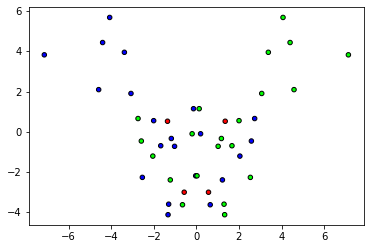

In [199]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.scatter(train_df['PC1'], train_df['PC2'], c=train_df['result'], cmap=cmap_bold,
            edgecolor='k', s=20)

In [200]:
match_features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

In [201]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(train_df[match_features], train_df['result'])

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [202]:
test_df['knn'] = clf.predict(test_df[match_features])
test_df[['result', 'knn']]

,result,knn
0,1,1
1,1,1
2,2,2
3,2,2
4,1,1
5,1,1
6,1,0
7,1,2
8,2,2
9,0,1


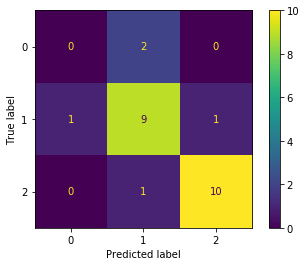

0.7916666666666666

In [203]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(
    clf,
    test_df[match_features],
    test_df['result'],
)#normalize='true')
plt.show()

confusion_matrix = confusion_matrix(test_df['result'], test_df['knn'], labels=[0, 1, 2])
np.diag(confusion_matrix).sum() / confusion_matrix.sum()

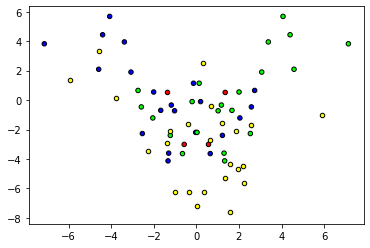

In [206]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.scatter(train_df['PC1'], train_df['PC2'], c=train_df['result'], cmap=cmap_bold,
            edgecolor='k', s=20)

plt.scatter(test_df['PC1'], test_df['PC2'], c='yellow',
            edgecolor='k', s=20)

# Pronóstico

In [220]:
nonplayed_matches = [
    ['España', 'Hungría'],
    ['Croacia', 'España'],
    ['Dinamarca', 'Países Bajos'],
    ['República Checa', 'Polonia'],
    ['Francia', 'Alemania']
]

nonplayed_matches = [
    [country_abbr(teamA), country_abbr(teamB)]
    for teamA, teamB in nonplayed_matches
]
nonplayed_matches

[['ESP', 'HUN'],
 ['CRO', 'ESP'],
 ['DEN', 'NED'],
 ['CZE', 'POL'],
 ['FRA', 'GER']]

In [222]:
test_df = generate_data(nonplayed_matches, teams_df)
test_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,A_FBGoals,A_FBMissed,A_FTOGoals,A_FTOMissed,A_9mGoals,A_9mMissed,A_RC,A_2M,A_AS,A_R7,A_ST,A_BS,A_P7,A_TO,A_cluster,B_7mPGoals,B_7mPMissed,B_6mCGoals,B_6mCMissed,B_WingGoals,B_WingMissed,B_BTGoals,B_BTMissed,B_FBGoals,B_FBMissed,B_FTOGoals,B_FTOMissed,B_9mGoals,B_9mMissed,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result
0,ESP,HUN,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79,4,-1
1,CRO,ESP,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98,3,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,-1
2,DEN,NED,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81,1,-1
3,CZE,POL,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40,0,9,2,10,2,15,10,7,4,7,3,0,0,19,35,0,12,37,11,11,12,12,44,0,-1
4,FRA,GER,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72,1,-1


In [223]:
X_scaled = scaler.transform(test_df[match_features])
X_pca = estimator.transform(X_scaled)

test_df['PC1'] = X_pca[:,0]
test_df['PC2'] = X_pca[:,1]
test_df['PC3'] = X_pca[:,2]
test_df['PC4'] = X_pca[:,3]
test_df['PC5'] = X_pca[:,4]
test_df['PC6'] = X_pca[:,5]

test_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,A_FBGoals,A_FBMissed,A_FTOGoals,A_FTOMissed,A_9mGoals,A_9mMissed,A_RC,A_2M,A_AS,A_R7,A_ST,A_BS,A_P7,A_TO,A_cluster,B_7mPGoals,B_7mPMissed,B_6mCGoals,B_6mCMissed,B_WingGoals,B_WingMissed,B_BTGoals,B_BTMissed,B_FBGoals,B_FBMissed,B_FTOGoals,B_FTOMissed,B_9mGoals,B_9mMissed,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result,PC1,PC2,PC3,PC4,PC5,PC6
0,ESP,HUN,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,17,6,14,10,46,36,25,13,19,6,0,2,35,62,0,13,80,24,23,11,25,79,4,-1,0.384013,-2.443598,-2.192524,-1.108814,1.073566,1.779946
1,CRO,ESP,16,7,49,12,41,32,20,4,10,7,0,0,57,84,2,28,96,25,33,15,42,98,3,26,5,24,16,50,39,5,11,16,7,1,1,25,35,1,24,83,31,24,10,21,94,1,-1,-2.937590,-0.713478,2.796800,-3.535070,-0.006748,0.912770
2,DEN,NED,20,7,23,15,75,39,21,5,22,7,3,0,45,71,0,25,94,27,39,29,32,84,3,21,7,29,8,51,49,23,16,28,13,0,2,41,68,0,22,105,28,34,15,23,81,1,-1,-1.021724,0.781540,-1.071546,-1.887895,-1.650016,0.259969
3,CZE,POL,8,5,4,3,22,10,5,3,5,4,0,0,25,40,0,10,22,13,12,3,24,40,0,9,2,10,2,15,10,7,4,7,3,0,0,19,35,0,12,37,11,11,12,12,44,0,-1,-0.531489,-9.688618,-3.312961,-0.361244,0.038849,-0.396314
4,FRA,GER,21,11,36,24,56,34,17,4,38,12,0,0,41,48,1,26,90,32,55,20,34,96,3,15,12,24,12,32,27,22,14,20,11,0,0,32,63,0,27,76,27,26,13,30,72,1,-1,0.486144,1.396396,1.517700,-3.168515,-1.901690,0.101292


In [224]:
match_features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

test_df['knn'] = clf.predict(test_df[match_features])
test_df[['teamA', 'teamB', 'knn']]

,teamA,teamB,knn
0,ESP,HUN,0
1,CRO,ESP,1
2,DEN,NED,1
3,CZE,POL,1
4,FRA,GER,1


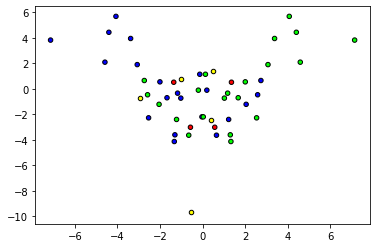

In [225]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.scatter(train_df['PC1'], train_df['PC2'], c=train_df['result'], cmap=cmap_bold,
            edgecolor='k', s=20)

plt.scatter(test_df['PC1'], test_df['PC2'], c='yellow',
            edgecolor='k', s=20)